# Learning What Affect Hotels Reviews

In [262]:
import warnings
warnings.filterwarnings("ignore")
import os.path
from os import path
import pandas as pd
import spacy
import gensim 
from os import listdir
from tqdm import tqdm
import numpy as np
import random
import codecs
from sklearn.decomposition import PCA
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans 
import subprocess 
import os
import re
import string
from os.path import isfile, join
import logging
import pickle
import multiprocessing
from sklearn.metrics import pairwise_distances_argmin_min
from scipy import spatial
import matplotlib.pyplot as plt
import time
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBClassifier
import gensim.downloader as api
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from wordcloud import WordCloud, STOPWORDS
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
cores = multiprocessing.cpu_count() 
print("Using", cores, "cores.")
# nltk.download()

Using 8 cores.


## TO-DO

* Fix google model (when loading it from cache)
* Cite https://www.kaggle.com/charlessamuel/trip-advisor-hotel-reviews-bert on visuallization part

## Hyper-Parameters

In [3]:
word2vec_embedding_size = 100  # Google uses dim = 300
use_cache = True
use_pretrained_google_model = False
sentiment_mode = False 
mode = 'regression'  # 'classification'
balanced_classes = True 
visualization = True

# Datasets

In [4]:
data = pd.read_csv("tripadvisor_hotel_reviews.csv")
print("Dataset size:", len(data))
data.head()

Dataset size: 20491


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## Visualization 

In [5]:
summ, total = 0, 0
for rev in data.Review.values:
    summ += len(rev.split(" "))
    total += 1
print("Avg. len for review:", summ/total)

Avg. len for review: 106.3750427016739


<AxesSubplot:xlabel='Rating', ylabel='count'>

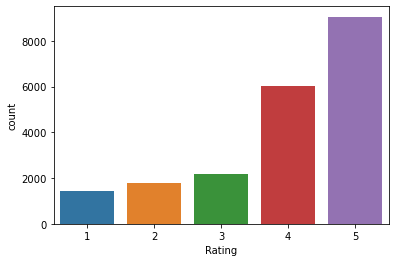

In [6]:
sns.countplot(data=data,x='Rating')

,frequently_used_word,count
0,hotel,42079
1,not,30750
2,room,30532
3,great,18732
4,n't,18436
5,staff,14950
6,good,14791
7,did,13433
8,just,12458
9,stay,11376


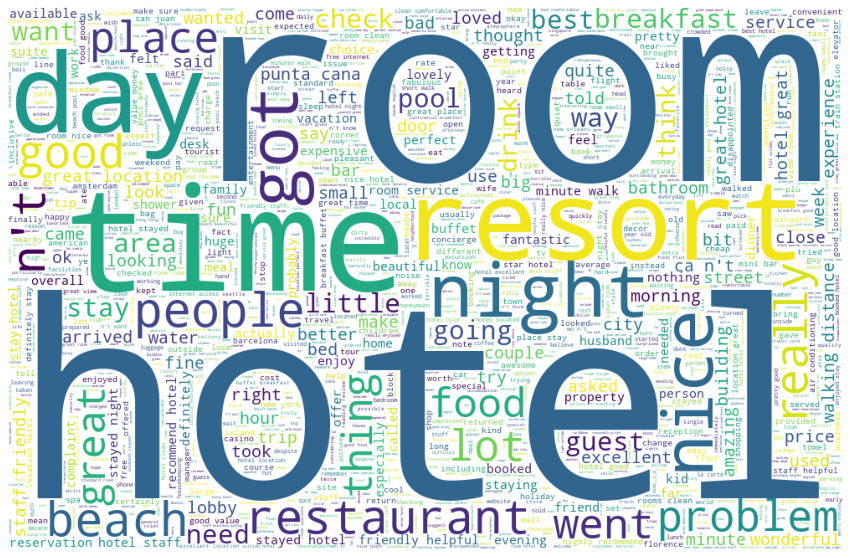

In [7]:
if visualization:
    word_list = []
    for sent in data['Review'].values:
        word_list += sent.split(" ")
    word_list = [word for word in word_list if word != '']
    words_collection = Counter(word_list)
    freq_word_df = pd.DataFrame(words_collection.most_common(15))
    freq_word_df.columns = ['frequently_used_word','count']
    display(freq_word_df.style.background_gradient(cmap='PuBuGn', low=0, high=0, axis=0, subset=None))
    
    word_string = " ".join(word_list)
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=60000, width=1000, height=650).generate(word_string)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

# Sentiment Mode

In [8]:
pos = [4, 5]
neg = [1, 2]
neu = [3]

def sentiment(rating):
    if rating in pos:
        return 2
    elif rating in neg:
        return 0
    else:
        return 1  

if sentiment_mode:
    data['Rating'] = data['Rating'].apply(sentiment)
    sns.countplot(data=data,x='Rating')

# Tokenizer

In [9]:
def clean_sentence(sent):
    sentence = sent.lower()   # lower case
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(sentence)  # tokenizer
    stop_words = stopwords.words('english')
    tokens = [i for i in tokens if i not in stop_words] # stop words
    return tokens


def get_corpus(data):
    corpus = []
    reviews = data.Review.values
    for rev in tqdm(reviews):
        tokens = clean_sentence(rev)
        corpus.append(tokens)
    return corpus


def load_corpus(data, use_cache=True):
    corpus_path = 'cache/corpus.model'
    if not use_cache or not path.exists(corpus_path):
        corpus = get_corpus(data)
        with open(corpus_path, 'wb') as f:
            pickle.dump(corpus, f)
    else:
        with open(corpus_path, 'rb') as f:
            corpus = pickle.load(f)
    return corpus

### Load Corpus

In [10]:
corpus = load_corpus(data, use_cache)
print("Load corpus:", len(corpus))

Load corpus: 20491


### Example

In [11]:
s = data.Review[1]
s

'ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman bu

In [12]:
' '.join(clean_sentence(s))

'ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle start booked suite paid extra website description suite bedroom bathroom standard hotel room took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast got kidding embassy suits sitting room bathroom bedroom unlike kimpton calls suite 5 day stay offer correct false advertising send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty reply solution send email trip guest survey follow email mail guess tell concerned guestthe staff ranged indifferent helpful asked desk good breakfast spots neighborhood hood told hotels gee best breakfast spots seattle 12 block away convenient hotel know exist arrived late night 11 pm inside run bellman busy chating cell phone help bagsprior arrival email

# Word2Vec

In [13]:
if not use_pretrained_google_model:
    model_file = 'cache/word2vec.model'
    if not path.exists(model_file) or not use_cache:
        word2vec = gensim.models.Word2Vec(min_count=1,
                             window=5,
                             size=word2vec_embedding_size,
                             alpha=0.03, 
                             workers=cores-1)
        word2vec.build_vocab(corpus, progress_per=10000)
        word2vec.train(corpus, total_examples=word2vec.corpus_count, epochs=30, report_delay=1)
        word2vec.init_sims(replace=True)
        word2vec.save(model_file)  
    else:
        word2vec = gensim.models.Word2Vec.load(model_file)
        
else:
    model_file = 'cache/word2vec_google.model'
    if not path.exists(model_file) or not use_cache:
        word2vec = api.load('word2vec-google-news-300')
        word2vec.save(model_file)
    else:
        word2vec = gensim.models.Word2Vec.load(model_file)

# Review2Vec

From the article: https://openreview.net/pdf?id=SyK00v5xx

In [14]:
def sif_embeddings(sentences, model, alpha=1e-3):
    REAL = np.float32 
    """Compute the SIF embeddings for a list of sentences
    Parameters
    ----------
    sentences : list
        The sentences to compute the embeddings for
    model : `~gensim.models.base_any2vec.BaseAny2VecModel`
        A gensim model that contains the word vectors and the vocabulary
    alpha : float, optional
        Parameter which is used to weigh each individual word based on its probability p(w).
    Returns
    -------
    numpy.ndarray 
        SIF sentence embedding matrix of dim len(sentences) * dimension
    """
    vlookup = model.wv.vocab  # Gives us access to word index and count
    vectors = model.wv        # Gives us access to word vectors
    size = model.vector_size  # Embedding size
    
    Z = 0
    for k in vlookup:
        Z += vlookup[k].count # Compute the normalization constant Z
    
    output = []
    
    # Iterate all sentences
    for s in tqdm(sentences):
        count = 0
        v = np.zeros(size, dtype=REAL) # Summary vector
        # Iterare all words
        for w in s:
            # A word must be present in the vocabulary
            if w in vlookup:
                for i in range(size):
                    v[i] += ( alpha / (alpha + (vlookup[w].count / Z))) * vectors[w][i]
                count += 1 
                
        if count > 0:
            for i in range(size):
                v[i] *= 1/count
        output.append(v)
    return np.vstack(output).astype(REAL)

### Get Reviews Embeddings

In [15]:
if use_pretrained_google_model:
    model_file = 'cache/reviews_embeddings_google.pkl'
else:
    model_file = 'cache/reviews_embeddings.pkl'

In [16]:
if path.exists(model_file) and use_cache:
    with open(model_file, 'rb') as f:
        reviews_embeddings = pickle.load(f)      
else:
    reviews_embeddings = sif_embeddings(corpus, word2vec)
    with open(model_file, 'wb') as f:
        pickle.dump(reviews_embeddings, f)

print("Load embedding:", reviews_embeddings.shape)

Load embedding: (20491, 100)


# Model

In [73]:
X = pd.DataFrame.from_records(reviews_embeddings)
y = data.Rating.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
19381,0.011416,0.009829,0.017404,-0.002232,0.011424,-0.002106,0.005223,0.000988,0.008911,-0.000322,...,0.003116,0.003433,-0.002680,-0.002523,-0.001687,0.023663,-0.004701,0.000250,-0.016101,0.015591
15438,-0.019198,0.001527,0.016130,0.020661,-0.023322,-0.007723,0.012685,0.000864,0.016870,0.026009,...,0.003616,-0.000157,-0.009549,-0.000124,-0.010126,0.004242,0.001905,-0.009446,0.005003,0.010856
2021,0.016920,-0.005476,-0.007735,0.004833,0.008000,-0.003455,0.010960,0.001843,0.009111,0.000999,...,-0.019142,-0.010179,-0.001796,0.006805,-0.010849,0.011157,0.014471,-0.012644,-0.005880,0.009787
12439,0.017166,0.024100,0.013687,0.013801,-0.007822,-0.008101,0.000351,-0.013043,0.008093,-0.005502,...,-0.012627,0.012710,-0.004029,-0.001329,0.004563,0.005501,-0.017533,-0.007159,-0.009127,0.010482
4179,0.019349,-0.020764,-0.009929,-0.007813,0.007186,0.023444,0.013352,0.004233,-0.029166,-0.003744,...,-0.024308,0.027745,-0.005678,0.011157,0.047734,0.011070,0.021117,-0.033558,-0.005526,0.027358


## XGBoost

### Hyper-Param Search

In [74]:
# model = XGBClassifier() 

# parameters = {'nthread':[4],
#               'objective':['multi:softmax'],
#               'learning_rate': [0.05, 0.01, 0.001, 0.005], 
#               'max_depth': [3, 4, 5, 6, 7],
#               'min_child_weight': [1, 2, 3, 5, 7],
#               'colsample_bytree': [0.2, 0.3, 0.5],
#               'n_estimators': [300, 500, 750, 1000]}


# clf = GridSearchCV(model, parameters, n_jobs=-1, 
#                    cv=StratifiedKFold(n_splits=3, shuffle=True), 
#                    scoring='accuracy',
#                    verbose=2, refit=True)

# clf.fit(X_train, y_train)

# print(clf.best_params_)

### Training

In [252]:
if mode == 'classification':
    model = XGBClassifier(
        colsample_bytree = 0.2,
        learning_rate = 0.005,
        max_depth = 10,
        min_child_weight = 3,
        n_estimators = 1000,
        nthread = 4,
        # objective = 'multi:softmax'
    ) 
    # model = AdaBoostClassifier()
    # model = MLPClassifier(random_state=1, max_iter=500)

else: 
#     model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree=0.25, learning_rate=0.7,
#                     max_depth=5, alpha=10, n_estimators=10)
#     model = xgb.XGBRegressor(objective ='reg:linear')
    model = LogisticRegression(C=50000, solver='newton-cg')

In [253]:
if balanced_classes: 
    print("Created balanced train dataset")   
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)

Created balanced train dataset


In [254]:
model.fit(X_train, y_train)

LogisticRegression(C=50000, solver='newton-cg')

### Predict 

In [255]:
y_pred = model.predict(X_test) 

In [256]:
predictions = [round(value) for value in y_pred]

# TODO: ADD OPTION FOR SENTIMANTE MODE (1-3)
for ii, p in enumerate(predictions):
    if p < 1:
        predictions[ii] = 1
    if p > 5:
        predictions[ii] = 5

### Evaluation

In [257]:
accuracy = accuracy_score(y_test, predictions) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 56.78%


In [258]:
if mode == 'classification':
    print(classification_report(y_test, y_pred))
    
else:
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print("RMSE: %.3f" % (rmse))
    print(classification_report(y_test, predictions))

RMSE: 0.865
              precision    recall  f1-score   support

           1       0.59      0.70      0.64       370
           2       0.40      0.45      0.43       443
           3       0.28      0.43      0.34       507
           4       0.50      0.47      0.49      1558
           5       0.77      0.67      0.71      2245

    accuracy                           0.57      5123
   macro avg       0.51      0.54      0.52      5123
weighted avg       0.60      0.57      0.58      5123



# Counterfactual Examples

TO-DO:
* remove sent with zero score (N)
* add window size 

In [296]:
POS_ADJS = ["good", "nice", "great"]
NEG_ADJS = ["bad", "awful"]

def find_sentences_with_concepts(review, concepts):
    sentences_list = re.split('\.|,|\?|!|;|:', review)
    return [sentence for sentence in sentences_list if all([concept in sentence for concept in concepts])]

def gen_counter_sentence(concept, is_positive):
    adj = random.choice(POS_ADJS) if is_positive else random.choice(NEG_ADJS)
    return "{} is {}".format(concept, adj)

def gen_synthetic_counter_examples(data, concept):
    reviews = data.Review.values
    original_reviews = []
    counter_reviews = []
    neutral_reviews = []
    concept_conotation = []
    reviews_score = []
   
    sia = SentimentIntensityAnalyzer()
    concepts = concept.split(" ")
    
    for review_idx, review in enumerate(reviews):
        sentences = find_sentences_with_concepts(review, concepts)
        if len(sentences) > 1:
            counter_review = review
            neutral_review = review
           
            for sentence in sentences:
                scores = sia.polarity_scores(sentence)                
                is_positive = scores["compound"] > 0
                counter_sentence = gen_counter_sentence(concept, not is_positive)
                counter_review = counter_review.replace(sentence, counter_sentence)
                neutral_review = neutral_review.replace(sentence, "")
               
            original_reviews.append(review)
            counter_reviews.append(counter_review)
            neutral_reviews.append(neutral_review)
            concept_conotation.append(is_positive)
            reviews_score.append(data.Rating.values[review_idx])
               
    return (original_reviews, counter_reviews, neutral_reviews, concept_conotation, reviews_score)

## Concept - Room Size

In [297]:
concept = "room size"
original_reviews, counter_reviews, neutral_reviews, concept_conotation, reviews_score = gen_synthetic_counter_examples(data, concept)

In [298]:
df = pd.DataFrame(list(zip(original_reviews, counter_reviews, neutral_reviews, concept_conotation, reviews_score)), columns =['Original', 'Counterfactual', 'Neutral', 'Treatment', 'Score'])
df['Treatment'] = df['Treatment'].astype(int)
df

,Original,Counterfactual,Neutral,Treatment,Score
0,ace not place husband stayed ace hotel seattle...,ace not place husband stayed ace hotel seattle...,ace not place husband stayed ace hotel seattle...,1,3
1,nice place good staff clean good location used...,nice place good staff clean good location used...,nice place good staff clean good location used...,1,5
2,"nice rate bed did n't really problem property,...","nice rate bed did n't really problem property,...","nice rate bed did n't really problem property,...",1,4
3,"overpriced not great disappointing property, s...","overpriced not great disappointing property, s...","overpriced not great disappointing property, s...",0,1
4,price right stayed travelodge mid-late march 2...,price right stayed travelodge mid-late march 2...,price right stayed travelodge mid-late march 2...,1,3
...,...,...,...,...,...
136,great stay l hotel stayed l hotel hk week dec ...,great stay l hotel stayed l hotel hk week dec ...,great stay l hotel stayed l hotel hk week dec ...,1,5
137,good modern choice just bit way wife stayed mo...,good modern choice just bit way wife stayed mo...,good modern choice just bit way wife stayed mo...,0,3
138,great price location stayed fontaine villa shi...,great price location stayed fontaine villa shi...,great price location stayed fontaine villa shi...,1,5
139,"sumner excellent, just got trip london loved s...","sumner excellent, just got trip london loved s...","sumner excellent, just got trip london loved s...",1,5
